<a href="https://colab.research.google.com/github/kahf10/DeepLearning/blob/main/KahfHussain_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [68]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.optimizers import RMSprop
from urllib.request import urlretrieve 
from keras.utils import to_categorical
import seaborn as sns
import numpy as np
import random
import sys
import re, cgi

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [43]:
url1 = 'https://www.gutenberg.org/cache/epub/11/pg11.txt' #Alice Adventures in Wonderland
url2 = 'https://www.gutenberg.org/cache/epub/2542/pg2542.txt' #A doll's house

urlretrieve(url1, 'book1.txt')
urlretrieve(url2, 'book2.txt')

text1 = open("book1.txt", encoding='utf-8').read().lower()
text2 = open("book2.txt", encoding='utf-8').read().lower()

print(len(text1), len(text2)) # Difference between the length of the two books. 

164016 161402


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

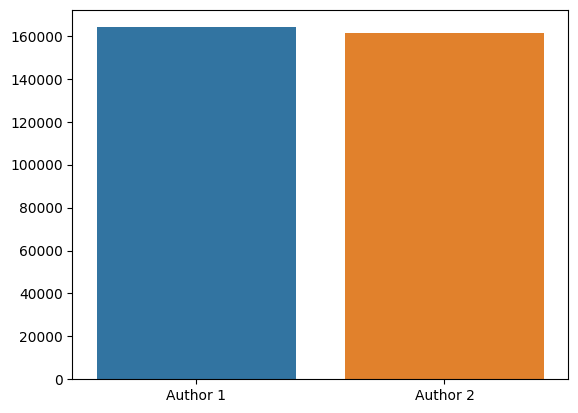

In [44]:
x_data = ['Author 1', 'Author 2']
y_data = [len(text1), len(text2)]

sns.barplot(x=x_data, y=y_data)
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [49]:
combined_text = text1 + text2 # Combining the two texts 
unique_chars = sorted(list(set(combined_text))) # Finding the unique characters

#Mapping unique characters to integers
char_to_int = {} 
for i, c in enumerate(unique_chars): #Dictionary Mapping 
    char_to_int[c] = i 

# Generating sequences and assigning labels 
sequenceLength = 60 # As given in the problem 
sequences = []
labels = []

for i in range(0, len(combined_text) - sequenceLength, 10):
    seq = combined_text[i:i+sequenceLength]
    label = 0 if i < len(text1) else 1 # Determine the label based on whether the sequence comes from text1 or text2
    seq_int = [char_to_int[char] for char in seq] # Convert the sequence of characters to a sequence of integer indices using char_to_int dictionary
    sequences.append(seq_int)
    labels.append(label)

sequences = np.array(sequences) #Converting list of sequences to a numpy array
labels = to_categorical(labels) #Preparing labels to be converted to one-hot encodings

#Converting characters to one-hot encodings 
alphabet_length = len(unique_chars)
one_hot_sequences = np.zeros((len(sequences), sequenceLength, alphabet_length), dtype=np.bool)
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        one_hot_sequences[i, t, char] = 1  

<ipython-input-49-ed9860d0a66a>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_sequences = np.zeros((len(sequences), sequenceLength, alphabet_length), dtype=np.bool)


## Data splitting
Split the data into train, validate and test sets. Make 

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [70]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequenceLength, alphabet_length)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(units=128, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

In [71]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 58, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 29, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 27, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dropout (Dropout)           (None, 128)              

## Model training
Train the model and apply early stopping.

In [73]:
es = EarlyStopping(patience=5, monitor="val_loss")

model.fit(X_train, Y_train, 
          validation_data = (X_val, Y_val),
          epochs=12, batch_size=32, 
          callbacks=[es])

Epoch 1/12
651/651 [==============================] - 41s 57ms/step - loss: 0.3737 - accuracy: 0.8107 - val_loss: 0.3037 - val_accuracy: 0.8498
Epoch 2/12
651/651 [==============================] - 32s 50ms/step - loss: 0.2395 - accuracy: 0.8864 - val_loss: 0.2310 - val_accuracy: 0.8947
Epoch 3/12
651/651 [==============================] - 33s 51ms/step - loss: 0.2119 - accuracy: 0.8971 - val_loss: 0.2081 - val_accuracy: 0.8990
Epoch 4/12
651/651 [==============================] - 33s 51ms/step - loss: 0.1878 - accuracy: 0.9088 - val_loss: 0.1833 - val_accuracy: 0.9130
Epoch 5/12
651/651 [==============================] - 34s 52ms/step - loss: 0.1702 - accuracy: 0.9151 - val_loss: 0.1792 - val_accuracy: 0.9116
Epoch 6/12
651/651 [==============================] - 33s 51ms/step - loss: 0.1505 - accuracy: 0.9229 - val_loss: 0.2023 - val_accuracy: 0.9013
Epoch 7/12
651/651 [==============================] - 33s 50ms/step - loss: 0.1446 - accuracy: 0.9244 - val_loss: 0.1649 - val_accuracy:

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [74]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

204/204 [==============================] - 2s 9ms/step - loss: 0.1496 - accuracy: 0.9123
Test loss: 0.1495629996061325
Test accuracy: 0.9122618436813354


## Confusion matrix
Calculate and display the confusion matrix.

204/204 [==============================] - 4s 18ms/step


<Axes: >

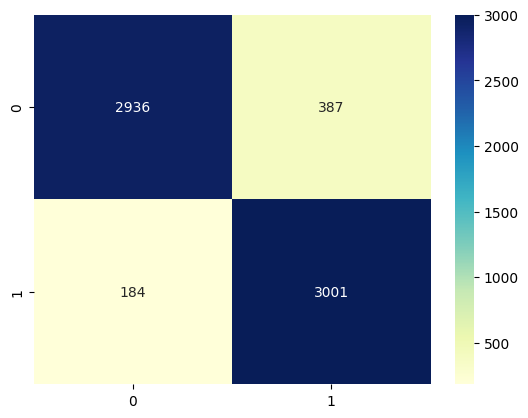

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', cmap="YlGnBu")